# Preprocess WaPOR data using python

This notebook contains step to preprocess WaPOR data
- [1. Read and write raster data](#1.-Read-and-write-raster-data)
- [2. Aggregate data in a period](#2.-Aggregate-data-in-a-period)
- [3. Warp raster data](#3.-Warp-raster-data)
- [4. Clip to Shapefile cutline](#4.-Clip-to-Shapefile-cutline)

In each step, you will find example codes and exercises to apply the example 

First, import libraries/packages so that the functions from these libaries can be used.

In [1]:
import os
import sys
import shapefile
import glob
import gdal
import osgeo
import osr
import ogr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
folder=r"..\..\modules"
sys.path.append(folder) #add folder with local modules to system paths
import WaPOR #import local module 'WaPOR'
WaPOR.API.getCatalog()

Loading WaPOR catalog...
Loading WaPOR catalog...Done


,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links,measure,dimension
0,L1_GBWP_A,Gross Biomass Water Productivity,The annual Gross Biomass Water Productivity ex...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 1, 'context': 'LEVELS...",WAPOR_2,RASTER,101,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'WPR', 'caption': 'Water Productivity...","[{'code': 'YEAR', 'caption': 'Year', 'descript..."
1,L1_NBWP_A,Net Biomass Water Productivity,The annual Net Biomass Water Productivity expr...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 2, 'context': 'LEVELS...",WAPOR_2,RASTER,102,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'WPR', 'caption': 'Water Productivity...","[{'code': 'YEAR', 'caption': 'Year', 'descript..."
2,L1_AETI_A,Actual EvapoTranspiration and Interception (An...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 3, 'context': 'LEVELS...",WAPOR_2,RASTER,103,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'WATER_MM', 'caption': 'Amount of Wat...","[{'code': 'YEAR', 'caption': 'Year', 'descript..."
3,L1_AETI_M,Actual EvapoTranspiration and Interception (Mo...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 4, 'context': 'LEVELS...",WAPOR_2,RASTER,104,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'WATER_MM', 'caption': 'Amount of Wat...","[{'code': 'MONTH', 'caption': 'Month', 'worksp..."
4,L1_AETI_D,Actual EvapoTranspiration and Interception (De...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 5, 'context': 'LEVELS...",WAPOR_2,RASTER,105,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'WATER_MM', 'caption': 'Amount of Wat...","[{'code': 'DEKAD', 'caption': 'Dekad (10-Days ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,L2_BAS_PHE_S,"Phenology (Seasonal, clipped by basin)","This is a system dataset, used to let the down...",NaN,NaN,WAPOR_2,RASTER,4151,"{'pixelTimeSeries': False, 'areaStatsTimeSerie...",True,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'PHE', 'caption': 'Phenology', 'descr...","[{'code': 'YEAR', 'caption': 'Year', 'descript..."
194,L2_BAS_QUAL_NDVI_D,Quality of Normalized Difference Vegetation In...,"This is a system dataset, used to let the down...",NaN,NaN,WAPOR_2,RASTER,4161,"{'pixelTimeSeries': False, 'areaStatsTimeSerie...",True,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'N_DAYS', 'caption': 'Number of Days'...","[{'code': 'DEKAD', 'caption': 'Dekad (10-Days ..."
195,L2_CTY_QUAL_NDVI_D,Quality of Normalized Difference Vegetation In...,"This is a system dataset, used to let the down...",NaN,NaN,WAPOR_2,RASTER,4162,"{'pixelTimeSeries': False, 'areaStatsTimeSerie...",True,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'N_DAYS', 'caption': 'Number of Days'...","[{'code': 'DEKAD', 'caption': 'Dekad (10-Days ..."
196,L2_BAS_QUAL_LST_D,"Quality Land Surface Temperature (Dekadal, cli...","This is a system dataset, used to let the down...",NaN,NaN,WAPOR_2,RASTER,4171,"{'pixelTimeSeries': False, 'areaStatsTimeSerie...",True,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'code': 'N_DAYS', 'caption': 'Number of Days'...","[{'code': 'DEKAD', 'caption': 'Dekad (10-Days ..."


## 1. Read and write raster data
### Example
In order to work with raster data in Python, we will need to open the raster dataset as a numerical array and do calculation with this array. The *gdal* package contains functions to work with raster mapset that can be used to do this task. Below are the steps to get these information from a GeoTIFF file. In this example, we will use the Level 1 monthly Actual Evapotranspiration and Interception (AETI) raster datasets downloaded in the exercise of the previous [notebook](1_Bulk_download_WaPOR_data.ipynb). 

First, to open a raster file, we will need the path to that file. In the code cell below, the code gets the list of raster files (in GeoTIFF format) in an input folder and then print out the path of the first file.

In [2]:
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M' #define input_folder
input_fhs=sorted(glob.glob(input_folder+'\*.tif')) #get list of tif files in the input_folder

in_fh=input_fhs[0] #get the path of the first file
print(in_fh)

.\data\WAPOR.v2_monthly_L1_AETI_M\L1_AETI_0901M.tif


A raster file has many properties including size, nodata value, transform, spatial reference, projection, etc. These information are stored in the dataset and can be read with *gdal* library functions. The code cell below read these informations from the metadata of the raster file **in_fh** using gdal library

In [3]:
DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly) #open raster in in_fh path

Type = DataSet.GetDriver().ShortName #GDAL driver
bandnumber=1 
Subdataset = DataSet.GetRasterBand(bandnumber) #Get the subdataset of band 1
NDV = Subdataset.GetNoDataValue() # No data value
xsize = DataSet.RasterXSize # number of columns in raster
ysize = DataSet.RasterYSize # number of rows in raster
GeoT = DataSet.GetGeoTransform() # Geo-transformation (coordinate of corner pixels)
Projection = osr.SpatialReference() # Spatial reference system of raster
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNodata Value: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection)) #print metadata

driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x000001C9F13A2090> > 
Nodata Value: -9999.0
xsize: 2851
ysize: 2461
GeoT: (37.45758935778001, 0.0022321428599999995, 0.0, 12.888392836720001, 0.0, -0.0022321428599999995)
Projection: GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


The data in the raster file can be read using *ReadAsArray* function. For example, the below code is used to read the opened GeoTIFF dataset as a numpy array. 
You can plot the data in this array using function in *matplotlib* library. Look at the example code and the output plot below. Notice where high AETI occurs. Since this is the data which show the monthly AETI, the unit of the color bar will be mm/month.

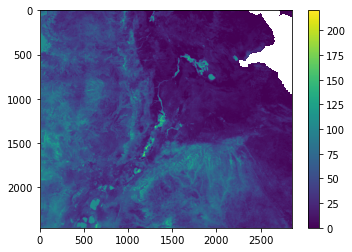

In [4]:
Array = Subdataset.ReadAsArray().astype(np.float32) #read sub-dataset as numpy array
Array[Array == NDV] = np.nan #replace No Data value with NAN value

plt.imshow(Array) #plot array as image
plt.colorbar()
plt.show()

Once opened as a numpy array, the raster dataset can be used in raster calculation by applying mathematical operations such as adding (+), substracting (-), multiplying ( * ), and dividing (/). For example, the code below calculate NewArray by dividing the Array by 30 (average number of days per month). The NewArray is then daily average AETI (mm/day). 

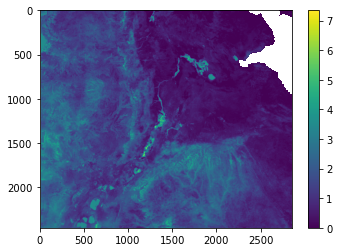

In [5]:
NewArray=Array/30
plt.imshow(NewArray)
plt.colorbar()
plt.show()

We can save this NewArray as a new raster file. To save our result as a raster file (GeoTIFF), we need to know the properties of the original raster file (driver, Nodata Value, size, extent, projection). Below is the example to save the above array as a new raster file. First, the output file name is defined and the output folder is created if it does not exist.

In [6]:
output_folder=r'.\data\daily_average_L1_AETI_M'
if not os.path.exists(output_folder): #check if output_folder exists
    os.makedirs(output_folder) #if not create the output_folder
filename=os.path.basename(in_fh) #get filename of the input file
out_fh=os.path.join(output_folder,filename) #output file path is defined
print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif


Then the *NewArray* value is saved as *out_fh* in the [output folder](data/daily_average_L1_AETI_M) using the codes below

In [7]:
datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32']) #create dataset from driver
DataSet.GetRasterBand(1).SetNoDataValue(NDV) #set Nodata value of the new dataset
DataSet.SetGeoTransform(GeoT) #set Geotransformation
DataSet.SetProjection(Projection.ExportToWkt()) 
DataSet.GetRasterBand(1).WriteArray(NewArray) #write the CorrectedArray values to the new dataset
print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif


### Exercise 1
You can make your own functions to read metadata, open raster file as array, and write array as raster file.
A function in Python is defined by *def* method

**def** Function(Inputs):

    Do something with Inputs
    
    return Output
    
**Hint**: Make use of the example scripts in the examples. 

In [8]:
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetGeoInfo(fh, subdataset = 0):
    '''
    This function extracts metadata from a GeoTIFF, HDF4 or netCDF file.      
    ''' 
    '''
    Write your code here
    ''' 
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    '''
    This function read a GeoTIFF or HDF4 file as an numpy array.
    ''' 
    '''
    Write your code here
    ''' 
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, 
                  Projection, explicit = True, compress = None):      
    '''
    This function saves a numpy array as a GeoTIFF raster file.
    ''' 
    '''
    Write your code here
    ''' 

In [9]:
import numpy as np
import gdal
import osr
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ogr
import datetime

def GetGeoInfo(fh, subdataset = 0):
    """
    Substract metadata from a geotiff, HDF4 or netCDF file.
    
    Parameters
    ----------
    fh : str
        Filehandle to file to be scrutinized.
    subdataset : int, optional
        Layer to be used in case of HDF4 or netCDF format, default is 0.
        
    Returns
    -------
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.
    """
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    """
    Open a map as an numpy array. 
    
    Parameters
    ----------
    fh: str
        Filehandle to map to open.
    bandnumber : int, optional 
        Band or layer to open as array, default is 1.
    dtype : str, optional
        Datatype of output array, default is 'float32'.
    nan_values : boolean, optional
        Convert he no-data-values into np.nan values, note that dtype needs to
        be a float if True. Default is False.
        
    Returns
    -------
    Array : ndarray
        Array with the pixel values.
    """
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16,
                 "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
                 "int32": np.int32, "float32": np.float32, "float64": np.float64, 
                 "complex64": np.complex64, "complex128": np.complex128,
                "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, 
                 "Complex64": np.complex64, "Complex128": np.complex128,}
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, Projection, explicit = True, compress = None):
    """
    Creates a geotiff from a numpy array.
    
    Parameters
    ----------
    fh : str
        Filehandle for output.
    Array: ndarray
        Array to convert to geotiff.
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.    
    """
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan


After complete and define the above functions, you can reuse them in the code below to calculate daily average AETI raster files from all the raster files in monthly AETI folder. To apply the same functions to all the raster files, we use a for-loop

**for** in_fh **in** input_fhs:

    functions
    
This means the script will iterate through all the file paths in **input_fhs**, which is the list of GeoTIFF file paths in the input folder. In each iteration, the raster file will be opened as array, used to compute new array, and the new array will be saved as a new raster file in output folder.

In [10]:
### Get input rasters
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M' #input folder
input_fhs=sorted(glob.glob(input_folder+'\*.tif')) #get list of .tif files in input_folder

output_folder=r'.\data\daily_average_L1_AETI_M' #output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
### Get GeoInfo
in_fh=input_fhs[0]
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(in_fh)

### Calculation
for in_fh in input_fhs:  
    ### Correct raster data with multiplier and number of days
    Array=OpenAsArray(in_fh,nan_values=True)
    NewArray=Array/30
    ### Save corrected array
    filename=os.path.basename(in_fh)
    out_fh=os.path.join(output_folder,filename)
    CreateGeoTiff(out_fh, NewArray, driver, NDV, xsize, ysize, GeoT, Projection)
    print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0902M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0903M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0904M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0905M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0906M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0907M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0908M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0909M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0910M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0911M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0912M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1001M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1002M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1003M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1004M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1005M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1006M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1007M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1008M.tif
.\data\daily_average

## 2. Aggregate data in a period

To aggregate data in a period is to combine all the raster files in a period to compute a new raster data. For example, we sum pixel values in all AETI raster datasets in a season together to compute total seasonal AETI. In the exercise of the previous [notebook](1_Bulk_download_WaPOR_data.ipynb), you have downloaded data for 2 years 2009 and 2010. In this example, we will compute total AETI for the season June 2009 to June 2010.

First, we will get the list of available raster files in the monthly AETI folder.

In [11]:
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M'
input_fhs=sorted(glob.glob(input_folder+'\*.tif'))
input_fhs

['.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0901M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0902M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0903M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0904M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0905M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0906M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0907M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0908M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0909M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0910M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0911M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0912M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1001M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1002M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1003M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1004M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1005M.tif

Then, we will use the WaPOR.API.getAvailData function to list all the raster ID available in the period from June 2009 to June 2010.

In [12]:
start='2009-06-01'
end='2010-06-30'
time_range=f'{start},{end}'
cube_code='L1_AETI_M'
df_avail=WaPOR.API.getAvailData(cube_code, time_range)
df_avail

,MONTH,raster_id,bbox,time_code
0,2009-06,L1_AETI_0906M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-06-01,2009-07-01)"
1,2009-07,L1_AETI_0907M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-07-01,2009-08-01)"
2,2009-08,L1_AETI_0908M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-08-01,2009-09-01)"
3,2009-09,L1_AETI_0909M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-09-01,2009-10-01)"
4,2009-10,L1_AETI_0910M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-10-01,2009-11-01)"
5,2009-11,L1_AETI_0911M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-11-01,2009-12-01)"
6,2009-12,L1_AETI_0912M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-12-01,2010-01-01)"
7,2010-01,L1_AETI_1001M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2010-01-01,2010-02-01)"
8,2010-02,L1_AETI_1002M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2010-02-01,2010-03-01)"
9,2010-03,L1_AETI_1003M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2010-03-01,2010-04-01)"


 The raster ID is also used as raster filename, so we can use this list to select only the files that belong to this period. Loop over the list of rasters in the folder and check if the raster_id in the raster filename belongs to the list of raster_id between 6/2009 and 6/2010. If so, the path of the file will be appended to the list of all files in the period.

In [13]:
period_fhs=[]
for in_fh in input_fhs:
    #get raster id from file name
    raster_id=os.path.basename(in_fh).split('.tif')[0] #get filename in path and exclude '.tif' extension
    #check if raster belong to period
    if raster_id in list(df_avail.raster_id): #if raster_id is in the list
        period_fhs.append(in_fh) #append the file path to period_fhs
period_fhs

['.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0906M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0907M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0908M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0909M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0910M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0911M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0912M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1001M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1002M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1003M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1004M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1005M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1006M.tif']

Now, we can iterate this list of all the raster files of this period and sum all their pixel values to compute the total AETI of the period.

In [14]:
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(period_fhs[0])
SumArray=np.zeros((ysize,xsize)) #create an zero array and same size with input rasters
for fh in period_fhs: #iterate over all the raster files in the period
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
out_fh=os.path.join(f'.\data\L1_AETI_{start}_{end}.tif')
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

The resulted raster can be plotted as below

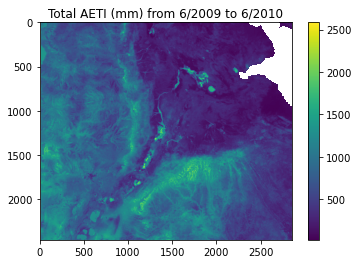

In [15]:
Array=OpenAsArray(out_fh,nan_values=True)
plt.imshow(Array)
plt.colorbar()
plt.title('Total AETI (mm) from 6/2009 to 6/2010')
plt.show()

## 3. Warp raster data

Spatial data come in different size, resolution, and spatial referencing system. For example, when open as array the size of Precipitation and AETI maps are different. Below is the size of Precipitaion raster.

(111, 128)


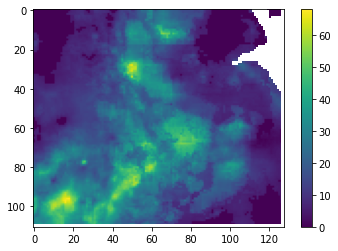

In [16]:
P_fh=r".\data\WAPOR.v2_monthly_L1_PCP_M\L1_PCP_0901M.tif"
P=OpenAsArray(P_fh,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

And below this cell is the size of AETI raster

(2461, 2851)


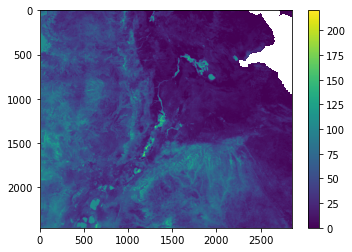

In [17]:
ET_fh=r".\data\WAPOR.v2_monthly_L1_AETI_M\L1_AETI_0901M.tif"
ET=OpenAsArray(ET_fh,nan_values=True)
print(ET.shape)
plt.imshow(ET)
plt.colorbar()
plt.show()

As we can see, the precipitation data has lower resolution (0.5 degree), thus, smaller array size (111x128) than the AETI data (250m and 2461x2851). To these two rasters in same calculation, they must be converted to the same size, resolution and projection. Here, we use the land-use map as the *template* to warp these data into the same form.

This can be done using the *gdal.Warp* function, an image mosaicing, reprojection and warping function. 
The *gdal.Warp* is used to warp the given raster data to pre-defined data size and spatial extent, reproject it to pre-defined spatial reference system.
To *gdal.Warp* a raster file to match projection, size, extent with another raster file, the information of the target file need to be obtained first. 
The below function is to get nodata value, spatial reference system, data size, spatial extent of a raster file using *gdal* package. 

For example, here the AETI map raster file is the target one. We want to match projection, size, extent of the source file, which is Precipitation, with the target file.

In [18]:
src_info=gdal.Info(gdal.Open(P_fh),format='json')
dst_info=gdal.Info(gdal.Open(ET_fh),format='json')

print('Source info: ',src_info,'\n')

print('Target info: ',dst_info)

Source info:  {'description': '.\\data\\WAPOR.v2_monthly_L1_PCP_M\\L1_PCP_0901M.tif', 'driverShortName': 'GTiff', 'driverLongName': 'GeoTIFF', 'files': ['.\\data\\WAPOR.v2_monthly_L1_PCP_M\\L1_PCP_0901M.tif'], 'size': [128, 111], 'coordinateSystem': {'wkt': 'GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID["WGS 84",6378137,298.257223563,\n            AUTHORITY["EPSG","7030"]],\n        AUTHORITY["EPSG","6326"]],\n    PRIMEM["Greenwich",0],\n    UNIT["degree",0.0174532925199433],\n    AUTHORITY["EPSG","4326"]]'}, 'geoTransform': [37.45000000000002, 0.05, 0.0, 12.9, 0.0, -0.05], 'metadata': {'': {'AREA_OR_POINT': 'Area'}, 'IMAGE_STRUCTURE': {'INTERLEAVE': 'BAND'}}, 'cornerCoordinates': {'upperLeft': [37.45, 12.9], 'lowerLeft': [37.45, 7.35], 'lowerRight': [43.85, 7.35], 'upperRight': [43.85, 12.9], 'center': [40.65, 10.125]}, 'wgs84Extent': {'type': 'Polygon', 'coordinates': [[[37.45, 12.9], [37.45, 7.35], [43.85, 7.35], [43.85, 12.9], [37.45, 12.9]]]}, 'bands': [{'band': 1, 'bl

After getting source *src_info* and target info *dst_info*, we can fill in these information to *gdal.Warp* as follow. The function will then resample precipitation raster data values to the same resolution as AETI raster. If the *gdal.Warp* function finished successfully, it will return a *osgeo.gdal.Dataset* object and the output raster file will be save in the [output folder](data/L1_PCP_M_warped)

In [19]:
source_file=P_fh
output_folder=r'.\data\L1_PCP_M_warped'
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_file=os.path.join(output_folder,filename) #create a output file path

gdal.Warp(output_file,P_fh,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001C9F1726750> >

The output precipiation raster file will now have the same size as AETI raster.

(2461, 2851)


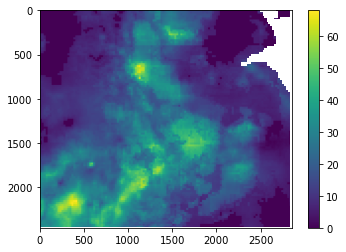

In [20]:
P=OpenAsArray(output_file,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

### Exercise 2
Make a user-defined function to warp any raster file with a given raster.
Use this function to match projection, size, extent of all precipitation with the ET data.

In [21]:
def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    This function warp all the raster files in a list to the same size, 
    resolution, and projection with a source raster file.
    """
    '''
    Write your code here
    '''
    return output_files

In [22]:
def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Matches the projection, resolution and no-data-value of a list of target-files
    with a source-file and saves the new maps in output_dir.
    
    Parameters
    ----------
    source_file : str
        The file to match the projection, resolution and ndv with.
    target_fhs : list
        The files to be reprojected.
    output_dir : str
        Folder to store the output.
    resample : str, optional
        Resampling method to use, default is 'near' (nearest neighbour).
    dtype : str, optional
        Datatype of output, default is 'float32'.
    scale : int, optional
        Multiple all maps with this value, default is None.
    
    Returns
    -------
    output_files : ndarray 
        Filehandles of the created files.
    """
    dst_info=gdal.Info(gdal.Open(source_file),format='json')
    output_files = np.array([])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for target_file in target_fhs:
        folder, fn = os.path.split(target_file)
        src_info=gdal.Info(gdal.Open(target_file),format='json')
        output_file = os.path.join(output_dir, fn)
        gdal.Warp(output_file,target_file,format='GTiff',
                      srcSRS=src_info['coordinateSystem']['wkt'],
                      dstSRS=dst_info['coordinateSystem']['wkt'],
                      srcNodata=src_info['bands'][0]['noDataValue'],
                      dstNodata=dst_info['bands'][0]['noDataValue'],
                      width=dst_info['size'][0],
                      height=dst_info['size'][1],
                      outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                    dst_info['cornerCoordinates']['lowerLeft'][1],
                                    dst_info['cornerCoordinates']['upperRight'][0],
                                    dst_info['cornerCoordinates']['upperRight'][1]),
                      outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                      resampleAlg=resample)
        output_files = np.append(output_files, output_file)
        if not np.any([scale == 1.0, scale == None, scale == 1]):
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = True) * scale
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
        if ndv_to_zero:
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = False)
            DATA[DATA == NDV] = 0.0
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_files

In [23]:
input_folder=r".\data\WAPOR.v2_monthly_L1_PCP_M"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_M_warped'
MatchProjResNDV(ET_fh, input_fhs, output_folder)

array(['.\\data\\L1_PCP_M_warped\\L1_PCP_0901M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0902M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0903M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0904M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0905M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0906M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0907M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0908M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0909M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0910M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0911M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0912M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1001M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1002M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1003M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1004M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1005M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1006M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1007M

## 4. Clip to Shapefile cutline

When we need to exclude pixels outside of region of interest, for example, in case of hydrological basin or irrigation block, we can use *gdal.Warp* with cutline option to clip a raster to the polygon boundary of a shapefile. The example codes below show how this is done with the precipitation raster maps.

First, we get the path to the input raster file and create an [output folder](data/L1_PCP_M_clipped)

In [24]:
input_fh=r".\data\WAPOR.v2_monthly_L1_PCP_M\L1_PCP_0901M.tif" # path to the raster to be clipped
shp_fh=r".\data\Awash_shapefile.shp" #path to the shapefile containing polygon of region of interest

output_folder=r'.\data\L1_PCP_M_clipped'#path to output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_fh=os.path.join(output_folder,filename) #create a output file path
print(output_fh)

.\data\L1_PCP_M_clipped\L1_PCP_0901M.tif


After defining the input and ouput raster file and the shapefile paths, we can use *ogr* library function to read shapefile dataset as gdal object to get the layer name. Then, use the shapefile path and layer as options arguments for *gdal.Warp* function. Check the output file in the [output folder](data/L1_PCP_M_clipped)

In [25]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #read shapefile as gdal dataset
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

Below is the map of input raster before clipping:

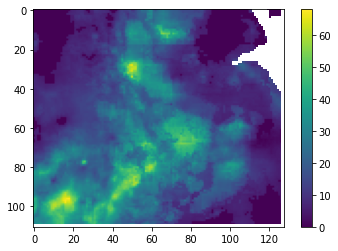

In [26]:
input_array=OpenAsArray(input_fh,nan_values=True)
plt.imshow(input_array)
plt.colorbar()
plt.show()

And below is the map of output raster after clipping:

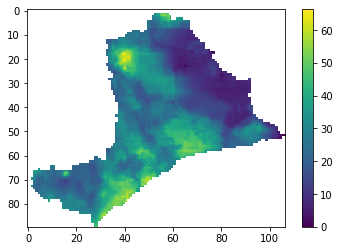

In [27]:
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

Notice that the original precipitation raster file has 5km spatial resolution. Therefore, when clip to cutline, we can see the coarse pixels on the boundary. If we need the cutline to be smoother, we can use the precipitation raster file that was warped to higher spatial resolution (250m) as input file. For example, see the difference between the map clipped from 5km resolution raster (above) and the map clipped from 250m resolution raster (below).

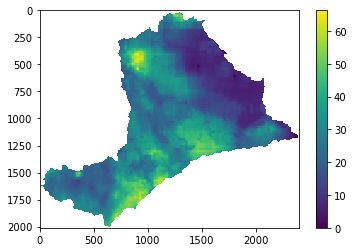

In [28]:
input_fh=r".\data\L1_PCP_M_warped\L1_PCP_0901M.tif"
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #read shapefile as gdal dataset
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

### Exercise 3

Create a function CliptoShp() to clip all warped monthly precipitation and all the monthly AETI and yearly LCC raster data downloaded from the exercise of the previous [notebook](1_Bulk_download_WaPOR_data.ipynb)

In [29]:
def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    Clip raster to boundary line of a shapefile
    
    """
    '''
    Write your scripts here
    '''
    return output_fhs

In [30]:
def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    Clip raster to boundary line of a shapefile
    
    Parameters
    ----------
    input_fhs : list
        The list of input raster files
    output_folder : str
        The path to folder where to save output rasters
    shp_fh : str
        Folder to store the output.
    NDV : float or int, optional
        No Data Value of output raster
        
    Returns
    -------
    output_fhs : list 
        Filehandles of the created files.
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )
    output_fhs=[]
    for input_fh in input_fhs:
        output_fh=os.path.join(output_folder,os.path.basename(input_fh))
        sourceds = gdal.Warp(output_fh, input_fh, options = options)
        output_fhs.append(output_fh)
    return output_fhs

Using the defined **CliptoShp** function, all the raster files in the input folders can be clipped to the polygon boundary of the shapefile. The output files will be saved in output folders.

In [31]:
input_folder=r".\data\L1_PCP_E_warped"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_M_clipped'
CliptoShp(input_fhs, output_folder,shp_fh)

input_folder=r".\data\WAPOR.v2_monthly_L1_AETI_M"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_AETI_M_clipped'
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
CliptoShp(input_fhs, output_folder,shp_fh)

input_folder=r".\data\WAPOR.v2_yearly_L1_LCC_A"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_LCC_A_clipped'
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
CliptoShp(input_fhs, output_folder,shp_fh)

['.\\data\\L1_LCC_A_clipped\\L1_LCC_09.tif',
 '.\\data\\L1_LCC_A_clipped\\L1_LCC_10.tif']